In [1]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import seaborn as sns
import os
import pickle
from tqdm import tqdm
import networkx as nx

In [2]:
NUM_SHOWERS_IN_BRICK = 200

In [3]:
import os
import psutil
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, log_loss
from sklearn.metrics import precision_recall_curve
from IPython.display import clear_output
import sys
sys.path.append("..")
from tools.opera_tools import plot_graphx, DISTANCE
from sklearn.linear_model import TheilSenRegressor, LinearRegression, HuberRegressor
from copy import deepcopy      
from collections import Counter

process = psutil.Process(os.getpid())

/home/vbelavin/home/anaconda3/envs/rootenv/lib/python3.6/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.14.2 is currently installed but you installed root_numpy against numpy 1.12.1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [4]:
def class_disbalance_graphx(graphx):
    signal = []
    for _, node in graphx.nodes(data=True):
        signal.append(node['signal'])
    return list(zip(*np.unique(signal, return_counts=True)))

def class_disbalance_graphx__(graphx):
    signal = []
    for _, node in graphx.nodes(data=True):
        signal.append(node['signal'])
    return np.unique(signal, return_counts=True)

In [5]:
from math import sqrt

def estimate_e(cluster, angle=0.05):
    x, y, z = estimate_start_xyz(cluster)
    tx, ty = estimate_txty(cluster)
    n = 0
    for i, node in cluster.nodes(data=True):
        dx = node['features']['SX'] - x
        dy = node['features']['SY'] - y
        dz = node['features']['SZ'] - z 
        dx = dx / dz - tx
        dy = dy / dz - ty
        dz = dz / dz
        if sqrt(dx**2 + dy**2) < angle:
            n += 1
            
    return n

def estimate_start_xyz(cluster, k=3, shift_x=0., shift_y=0., shift_z=-2000.):
    xs = []
    ys = []
    zs = []

    for i, node in cluster.nodes(data=True):
        xs.append(node['features']['SX'])
        ys.append(node['features']['SY'])
        zs.append(node['features']['SZ'])
    
    xs = np.array(xs)
    ys = np.array(ys)
    zs = np.array(zs)
    
    argosorted_z = np.argsort(zs)
    
    x = np.median(np.median(xs[argosorted_z][:k])) + shift_x
    y = np.median(np.median(ys[argosorted_z][:k])) + shift_y
    z = np.median(np.median(zs[argosorted_z][:k])) + shift_z
    
    return x, y, z

def estimate_txty(cluster, k=20):
    xs = []
    ys = []
    zs = []
    tx = []
    ty = []

    for i, node in cluster.nodes(data=True):
        xs.append(node['features']['SX'])
        ys.append(node['features']['SY'])
        zs.append(node['features']['SZ'])
        tx.append(node['features']['TX'])
        ty.append(node['features']['TY'])
        
    
    xs = np.array(xs)
    ys = np.array(ys)
    zs = np.array(zs)
    tx = np.array(tx)
    ty = np.array(ty)
    
    
    argosorted_z = np.argsort(zs)
    
    lr = TheilSenRegressor()
    lr.fit(zs[argosorted_z][:k].reshape((-1, 1)), xs[argosorted_z][:k])
    TX = lr.coef_[0]

    lr.fit(zs[argosorted_z][:k].reshape((-1, 1)), ys[argosorted_z][:k])
    TY = lr.coef_[0]
    
    return TX, TY
    return np.median(np.median(tx[argosorted_z][:k])), np.median(np.median(ty[argosorted_z][:k]))

## Load data

In [6]:
import pickle
with open('clusterized_bricks_{}.pickle'.format(NUM_SHOWERS_IN_BRICK), 'rb') as f:
    clusterized_bricks = pickle.load(f)

In [7]:
selected_tracks = 0
total_tracks = 0

number_of_lost_showers = 0
number_of_broken_showers = 0
number_of_stucked_showers = 0
total_number_of_showers = 0
number_of_good_showers = 0
number_of_survived_showers = 0
second_to_first_ratios = []

E_raw = []
E_true = []

x_raw = []
x_true = []

y_raw = []
y_true = []

z_raw = []
z_true = []

tx_raw = []
tx_true = []

ty_raw = []
ty_true = []

In [8]:
for clusterized_brick in tqdm(clusterized_bricks):
    showers_data = clusterized_brick['graphx'].graph['showers_data']
    clusters = clusterized_brick['clusters']
    for shower_data in showers_data:
        shower_data['clusters'] = []

    for cluster in clusters:
        selected_tracks += len(cluster)
        for label, label_count in class_disbalance_graphx(cluster):
            if label_count / showers_data[label]['numtracks'] >= 0.1:
                showers_data[label]['clusters'].append(cluster)

    for shower_data in showers_data:
        total_tracks += shower_data['numtracks']
        
    for shower_data in showers_data:
        total_number_of_showers += 1

        signals_per_cluster = []
        idx_cluster = []
        for i, cluster in enumerate(shower_data['clusters']):
            labels, counts = class_disbalance_graphx__(cluster)
            signals_per_cluster.append(counts[labels==shower_data['signal']][0])
            idx_cluster.append(i)
        signals_per_cluster = np.array(signals_per_cluster)
        idx_cluster = np.array(idx_cluster)
        second_to_first_ratio = 0.
        
        if len(signals_per_cluster) == 0:
            number_of_lost_showers += 1
            continue
        if len(signals_per_cluster) == 1:
            second_to_first_ratio = 0.
            second_to_first_ratios.append(second_to_first_ratio)
        else:
            second_to_first_ratio = np.sort(signals_per_cluster)[-2] / signals_per_cluster.max()
            second_to_first_ratios.append(second_to_first_ratio)

        cluster = shower_data['clusters'][np.argmax(signals_per_cluster)]

        # not enough signal
        if (signals_per_cluster.max() / shower_data['numtracks']) <= 0.1:
            continue

            
        labels, counts = class_disbalance_graphx__(cluster)
        counts = counts/ counts.sum()
        # high contamination
        if counts[labels==shower_data['signal']] < 0.9:
            number_of_stucked_showers += 1
            continue
        
        if second_to_first_ratio > 0.3:
            number_of_broken_showers += 1
            continue
            
            
        ## good showers next
        number_of_good_showers += 1
        # E
        E_raw.append(estimate_e(cluster))
        E_true.append(shower_data['ele_P'])

        # x, y, z
        x, y, z = estimate_start_xyz(cluster)

        x_raw.append(x)
        x_true.append(shower_data['ele_SX'])

        y_raw.append(y)
        y_true.append(shower_data['ele_SY'])

        z_raw.append(z)
        z_true.append(shower_data['ele_SZ'])

        # tx, ty
        tx, ty = estimate_txty(cluster)

        tx_raw.append(tx)
        tx_true.append(shower_data['ele_TX'])

        ty_raw.append(ty)
        ty_true.append(shower_data['ele_TY'])

100%|██████████| 10/10 [00:38<00:00,  3.87s/it]


In [9]:
E_raw = np.array(E_raw)
E_true =  np.array(E_true)

x_raw = np.array(x_raw)
x_true = np.array(x_true)

y_raw =  np.array(y_raw)
y_true =  np.array(y_true)

z_raw = np.array(z_raw)
z_true =np.array(z_true)

tx_raw = np.array(tx_raw)
tx_true =  np.array(tx_true)

ty_raw =  np.array(ty_raw)
ty_true =  np.array(ty_true)

All scales in micrometers, so to get precision in mm have o devide by 1000

In [10]:
scale_mm = 1000

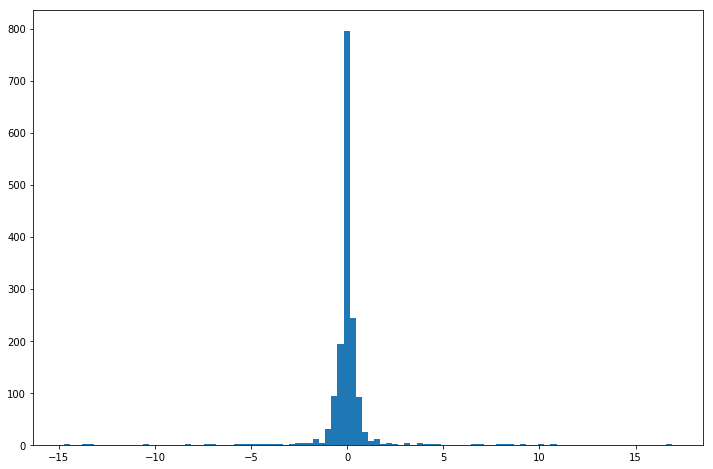

In [11]:
plt.figure(figsize=(12, 8))
plt.hist((x_raw - x_true) / scale_mm, bins=100);

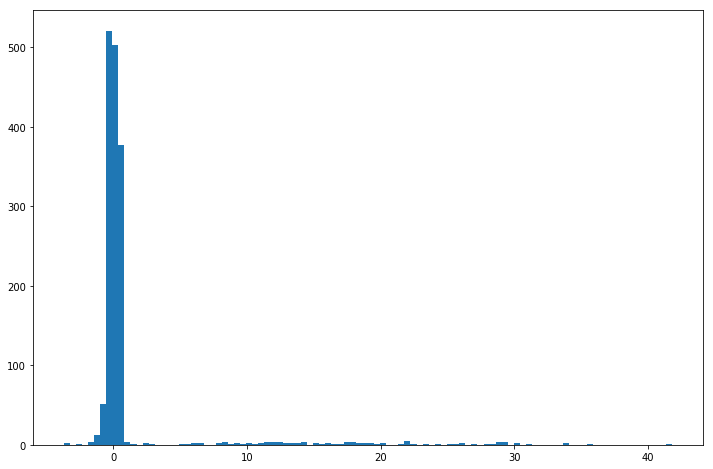

In [12]:
plt.figure(figsize=(12, 8))
plt.hist((z_raw - z_true) / scale_mm, bins=100);

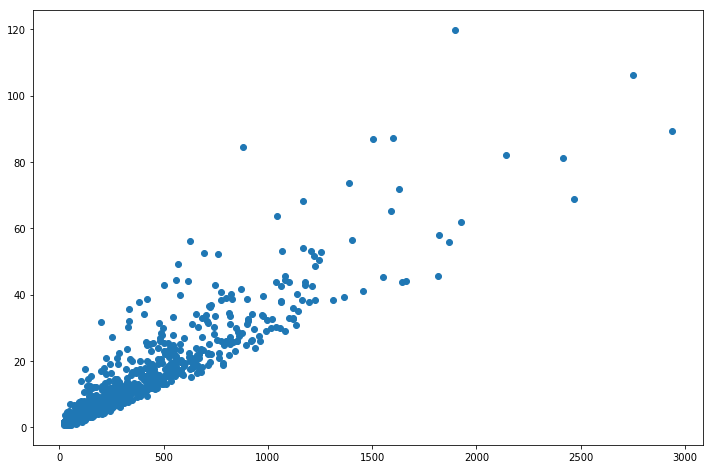

In [13]:
plt.figure(figsize=(12, 8))
plt.scatter(E_raw, E_true)

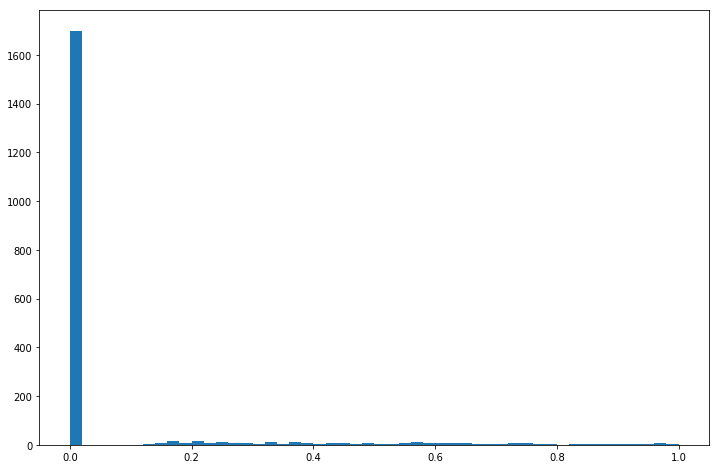

In [14]:
plt.figure(figsize=(12, 8))
plt.hist(second_to_first_ratios, bins=50);

In [15]:
r = HuberRegressor()

r.fit(X=E_raw.reshape((-1, 1)), y=E_true, sample_weight=1/E_true)

E_pred = r.predict(E_raw.reshape((-1, 1)))

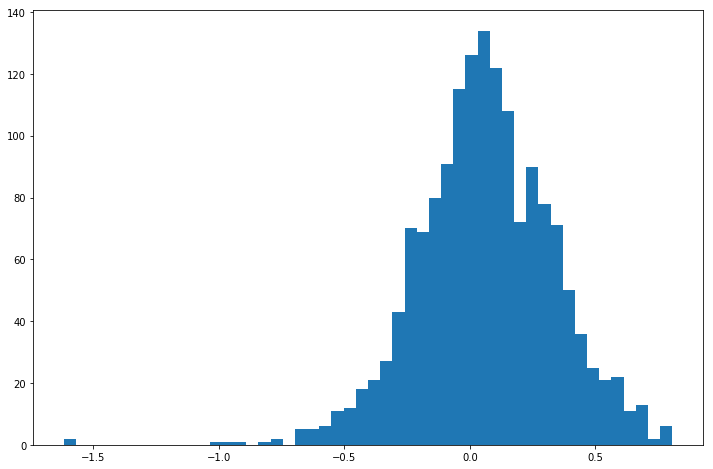

In [16]:
plt.figure(figsize=(12, 8))
plt.hist((E_true - E_pred) / E_true, bins=50);

In [17]:
print('Energy resolution = {}'.format(np.std((E_true - E_pred) / E_true)))
print()
print('Track efficiency = {}'.format(selected_tracks / total_tracks))
print()
print('Good showers = {}'.format(number_of_good_showers / total_number_of_showers))
print('Stuck showers = {}'.format(number_of_stucked_showers / total_number_of_showers))
print('Broken showers = {}'.format(number_of_broken_showers / total_number_of_showers))
print('Lost showers = {}'.format(number_of_lost_showers / total_number_of_showers))
print()
print('MAE for x = {}'.format(np.abs((x_raw - x_true) / scale_mm).mean()))
print('MAE for y = {}'.format(np.abs((y_raw - y_true) / scale_mm).mean()))
print('MAE for z = {}'.format(np.abs((z_raw - z_true) / scale_mm).mean()))
print()
print('MAE for tx = {}'.format(np.abs((tx_raw - tx_true)).mean()))
print('MAE for ty = {}'.format(np.abs((ty_raw - ty_true)).mean()))

Energy resolution = 0.27092643286862184

Track efficiency = 0.8683685995211414

Good showers = 0.784
Stuck showers = 0.1165
Broken showers = 0.0835
Lost showers = 0.015

MAE for x = 0.4454509457050614
MAE for y = 0.43971031904239144
MAE for z = 1.375612531389509

MAE for tx = 0.00639729012881406
MAE for ty = 0.0067943658577671005
